In [29]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# === CONFIGURE ===
folder_path = r"C:\Users\Abdullah\dispatch_outputs_solar-wind_dc"
years = list(range(2024, 1979, -1))
yearly_wind_energy = {}

# === COLLECT WIND ENERGY TOTALS ===
for year in years:
    file_path = os.path.join(folder_path, f"dispatch_data_{year}.csv")
    try:
        df = pd.read_csv(file_path)
        total_kwh = df['Wind (kW)'].sum()
        yearly_wind_energy[year] = total_kwh
    except FileNotFoundError:
        print(f"Missing: dispatch_data_{year}.csv")
        yearly_wind_energy[year] = None

# === FILTER VALID YEARS ===
valid_energies = {y: e for y, e in yearly_wind_energy.items() if e is not None}

if not valid_energies:
    print("No valid wind data found.")
else:
    # === FIND MAXIMUM YEAR AND ENERGY ===
    max_year = max(valid_energies, key=valid_energies.get)
    max_energy = valid_energies[max_year]  # in kWh

    # === EMISSIONS CALCULATION (6.6 g CO₂/kWh) ===
    co2e_per_kwh_kg = 6.6 / 1000  # convert to kg
    wind_lca_emissions_kg = max_energy * co2e_per_kwh_kg *15

    # === OUTPUT ===
    print(f"\nMaximum wind generation year: {max_year}")
    print(f"Wind energy generated: {max_energy:,.2f} kWh")
    print(f"Total Wind LCA CO₂-eq emissions over 15 years: {wind_lca_emissions_kg:,.2f} kg CO2")


Maximum wind generation year: 1996
Wind energy generated: 924,033,845.21 kWh
Total Wind LCA CO₂-eq emissions over 15 years: 91,479,350.68 kg CO2


In [31]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# === CONFIGURE ===
folder_path = r"C:\Users\Abdullah\dispatch_outputs_solar-wind_dc"
years = list(range(2024, 1979, -1))
yearly_wind_energy = {}

# === COLLECT WIND ENERGY TOTALS ===
for year in years:
    file_path = os.path.join(folder_path, f"dispatch_data_{year}.csv")
    try:
        df = pd.read_csv(file_path)
        total_kwh = df['Solar (kW)'].sum()
        yearly_wind_energy[year] = total_kwh
    except FileNotFoundError:
        print(f"Missing: dispatch_data_{year}.csv")
        yearly_wind_energy[year] = None

# === FILTER VALID YEARS ===
valid_energies = {y: e for y, e in yearly_wind_energy.items() if e is not None}

if not valid_energies:
    print("No valid solar data found.")
else:
    # === FIND MAXIMUM YEAR AND ENERGY ===
    max_year = max(valid_energies, key=valid_energies.get)
    max_energy = valid_energies[max_year]  # in kWh

    # === EMISSIONS CALCULATION (44 g CO₂/kWh) ===
    co2e_per_kwh_kg = 44 / 1000  # convert to kg
    solar_lca_emissions_kg = max_energy * co2e_per_kwh_kg *15

    # === OUTPUT ===
    print(f"\nMaximum solar generation year: {max_year}")
    print(f"Solar energy generated: {max_energy:,.2f} kWh")
    print(f"Total Solar LCA CO₂-eq emissions: {solar_lca_emissions_kg:,.2f} kg CO2")


Maximum solar generation year: 1988
Solar energy generated: 5,558,012,010.75 kWh
Total Solar LCA CO₂-eq emissions: 3,668,287,927.09 kg CO2


In [33]:
import pandas as pd

# === File path on your machine ===
file_path = r"C:\Users\Abdullah\dispatch_outputs_solar-wind_dc\capacity_and_costs_by_year.csv"

# === Load the data ===
df = pd.read_csv(file_path)

# === Get first battery capacity value ===
first_capacity_kwh = df.loc[0, 'Battery_Capacity_kWh']

# === Multiply by given factor ===
base_battery_lca = first_capacity_kwh * 151 #kgCO2/kWh

# === Output ===
print(f"First Battery Capacity: {first_capacity_kwh:,.6f} kWh")
print(f"Multiplied Result (×151): {base_battery_lca:,.2f} kgCO2")


First Battery Capacity: 5,959,201.565235 kWh
Multiplied Result (×151): 899,839,436.35 kgCO2


In [35]:
import os
import pandas as pd
import numpy as np

# === File Directory Configuration ===
folder_path = r"C:\Users\Abdullah\dispatch_outputs_solar-wind_dc"
years = list(range(2024, 1979, -1))

# === Store Total Degradation Per Year ===
yearly_degradation = {}

for year in years:
    file_path = os.path.join(folder_path, f"cycles_{year}.csv")
    try:
        df = pd.read_csv(file_path)
        if 'degradation' in df.columns:
            total_deg = df['degradation'].sum()
            yearly_degradation[year] = total_deg
        else:
            yearly_degradation[year] = None
    except FileNotFoundError:
        yearly_degradation[year] = None

# === Get Maximum Degradation Value ===
valid_degs = [v for v in yearly_degradation.values() if v is not None]
max_deg = max(valid_degs) if valid_degs else None

# === Use First Battery Capacity and Compute Replacement Capacity ===
battery_capacity_kwh = 5959201.565234834  # From earlier result

if max_deg is not None:
    replaced_battery_capacity_kwh = (battery_capacity_kwh / (1 - max_deg)) - battery_capacity_kwh
    replaced_battery_capacity_lca = replaced_battery_capacity_kwh * 151
else:
    replaced_battery_capacity_kwh = None
    replaced_battery_capacity_lca = None

max_deg, replaced_battery_capacity_kwh, replaced_battery_capacity_lca

replaced_battery_capacity_lca_15=replaced_battery_capacity_lca*15

# === Output ===
print(f"Max Replacment Battery Capacity Emissions over 15 years: {replaced_battery_capacity_lca_15:,.6f} kgCO2")


Max Replacment Battery Capacity Emissions over 15 years: 135,347,822.038509 kgCO2


In [37]:
Total_renewable_emissions=replaced_battery_capacity_lca_15+base_battery_lca+wind_lca_emissions_kg+solar_lca_emissions_kg

# === Output ===
print(f"Renewable System Emissions: {Total_renewable_emissions:,.6f} kgCO2")

Renewable System Emissions: 4,794,954,536.157236 kgCO2


# BAU Emissions

In [40]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from scipy.interpolate import make_interp_spline
hours = 8760
# Generate hourly dynamic PUE profile
quarter_midpoints = np.linspace(0, hours, 5)  # [0, 2190, 4380, 6570, 8760]
pue_targets = [1.09, 1.11, 1.13, 1.08, 1.09]  # Quarterly values
spline = make_interp_spline(quarter_midpoints, pue_targets, k=3)
hourly_pue = spline(np.arange(hours))

# Load the CSV
df_base = pd.read_csv('Desktop/base_power_profile.csv')

# Extract the 'Power_W' column as a NumPy array
base_power = df_base['Power_W'].to_numpy()

dc_ac_conversion_efficiency=0.975 
#PUE= 1.15 #
load_profile = (base_power[:hours] / 1000) * 200000 * 1.405 * (hourly_pue / dc_ac_conversion_efficiency)  # kW
# Pricing in $/kWh
grid_limit_kw = 150000  # 150 MW
grid_rate = 0.2892       # kgCO2e/kWh
gas_rate = 0.46        # kgCO2e/kWh

# Initialize cost array
hourly_cost = np.zeros_like(load_profile)

# Compute cost per hour
for i in range(hours):
    if load_profile[i] <= grid_limit_kw:
        hourly_cost[i] = load_profile[i] * grid_rate
    else:
        grid_energy = grid_limit_kw * grid_rate
        gas_energy = (load_profile[i] - grid_limit_kw) * gas_rate
        hourly_cost[i] = grid_energy + gas_energy

# Total cost for the year
total_annual_grid = np.sum(hourly_cost)

print(f"Total Annual Grid CO2 emissions: {total_annual_grid:,.2f} kgCO2")


Total Annual Grid CO2 emissions: 669,772,951.13 kgCO2


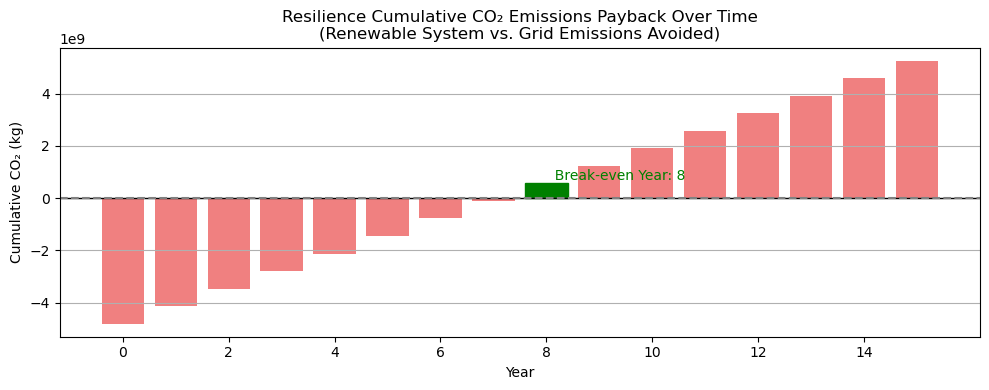

8

In [42]:
import matplotlib.pyplot as plt
import numpy as np


# === Project lifetime and CO2 flow ===
project_lifetime = 15  # Assume 30 years for LCA horizon

# CO2 flows: Year 0 is the "CO2 investment" (debt), rest are yearly avoided grid emissions
co2_flows = [-Total_renewable_emissions] + [total_annual_grid] * project_lifetime
cumulative_co2 = np.cumsum(co2_flows)

# Plotting
plt.figure(figsize=(10, 4))
bars = plt.bar(range(project_lifetime + 1), cumulative_co2, color='lightcoral')
plt.axhline(0, color='black', linewidth=1)
plt.axhline(y=0, linestyle='--', color='gray')

# Highlight break-even year
break_even_year = np.argmax(cumulative_co2 >= 0)
bars[break_even_year].set_color('green')

# Labels and title
plt.title('Resilience Cumulative CO₂ Emissions Payback Over Time\n(Renewable System vs. Grid Emissions Avoided)')
plt.xlabel('Year')
plt.ylabel('Cumulative CO₂ (kg)')
plt.xticks(range(0, project_lifetime + 1, 2))
plt.grid(axis='y')

# Optional annotation for break-even year
plt.text(break_even_year, cumulative_co2[break_even_year],
         f'  Break-even Year: {break_even_year}', color='green', va='bottom')

plt.tight_layout()
plt.show()

# Output payback year for reference
break_even_year


# Financial Case

In [15]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# === CONFIGURE ===
folder_path = r"C:\Users\Abdullah\dispatch_outputs_solar-wind_dc_98metLoadCostCurtailment"
years = list(range(2024, 1979, -1))
yearly_wind_energy = {}

# === COLLECT WIND ENERGY TOTALS ===
for year in years:
    file_path = os.path.join(folder_path, f"dispatch_data_{year}.csv")
    try:
        df = pd.read_csv(file_path)
        total_kwh = df['Wind (kW)'].sum()
        yearly_wind_energy[year] = total_kwh
    except FileNotFoundError:
        print(f"Missing: dispatch_data_{year}.csv")
        yearly_wind_energy[year] = None

# === FILTER VALID YEARS ===
valid_energies = {y: e for y, e in yearly_wind_energy.items() if e is not None}

if not valid_energies:
    print("No valid wind data found.")
else:
    # === FIND MAXIMUM YEAR AND ENERGY ===
    max_year = max(valid_energies, key=valid_energies.get)
    max_energy = valid_energies[max_year]  # in kWh

    # === EMISSIONS CALCULATION (6.6 g CO₂/kWh) ===
    co2e_per_kwh_kg = 6.6 / 1000  # convert to kg
    wind_lca_emissions_kg = max_energy * co2e_per_kwh_kg *15

    # === OUTPUT ===
    print(f"\nMaximum wind generation year: {max_year}")
    print(f"Wind energy generated: {max_energy:,.2f} kWh")
    print(f"Total Wind LCA CO₂-eq emissions over 15 years: {wind_lca_emissions_kg:,.2f} kg CO2")


Maximum wind generation year: 1996
Wind energy generated: 678,383,623.07 kWh
Total Wind LCA CO₂-eq emissions over 15 years: 67,159,978.68 kg CO2


In [16]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# === CONFIGURE ===
folder_path = r"C:\Users\Abdullah\dispatch_outputs_solar-wind_dc_98metLoadCostCurtailment"
years = list(range(2024, 1979, -1))
yearly_wind_energy = {}

# === COLLECT WIND ENERGY TOTALS ===
for year in years:
    file_path = os.path.join(folder_path, f"dispatch_data_{year}.csv")
    try:
        df = pd.read_csv(file_path)
        total_kwh = df['Solar (kW)'].sum()
        yearly_wind_energy[year] = total_kwh
    except FileNotFoundError:
        print(f"Missing: dispatch_data_{year}.csv")
        yearly_wind_energy[year] = None

# === FILTER VALID YEARS ===
valid_energies = {y: e for y, e in yearly_wind_energy.items() if e is not None}

if not valid_energies:
    print("No valid solar data found.")
else:
    # === FIND MAXIMUM YEAR AND ENERGY ===
    max_year = max(valid_energies, key=valid_energies.get)
    max_energy = valid_energies[max_year]  # in kWh

    # === EMISSIONS CALCULATION (44 g CO₂/kWh) ===
    co2e_per_kwh_kg = 44 / 1000  # convert to kg
    solar_lca_emissions_kg = max_energy * co2e_per_kwh_kg *15

    # === OUTPUT ===
    print(f"\nMaximum solar generation year: {max_year}")
    print(f"Solar energy generated: {max_energy:,.2f} kWh")
    print(f"Total Solar LCA CO₂-eq emissions: {solar_lca_emissions_kg:,.2f} kg CO2")


Maximum solar generation year: 1988
Solar energy generated: 3,740,481,285.86 kWh
Total Solar LCA CO₂-eq emissions: 2,468,717,648.67 kg CO2


In [19]:
import pandas as pd

# === File path on your machine ===
file_path = r"C:\Users\Abdullah\dispatch_outputs_solar-wind_dc_98metLoadCostCurtailment\capacity_and_costs_by_year.csv"

# === Load the data ===
df = pd.read_csv(file_path)

# === Get first battery capacity value ===
first_capacity_kwh = df.loc[0, 'Battery_Capacity_kWh']

# === Multiply by given factor ===
base_battery_lca = first_capacity_kwh * 151 #kgCO2/kWh

# === Output ===
print(f"First Battery Capacity: {first_capacity_kwh:,.6f} kWh")
print(f"Multiplied Result (×151): {base_battery_lca:,.2f} kgCO2")


First Battery Capacity: 3,591,077.972362 kWh
Multiplied Result (×151): 542,252,773.83 kgCO2


In [21]:
import os
import pandas as pd
import numpy as np

# === File Directory Configuration ===
folder_path = r"C:\Users\Abdullah\dispatch_outputs_solar-wind_dc_98metLoadCostCurtailment"
years = list(range(2024, 1979, -1))

# === Store Total Degradation Per Year ===
yearly_degradation = {}

for year in years:
    file_path = os.path.join(folder_path, f"cycles_{year}.csv")
    try:
        df = pd.read_csv(file_path)
        if 'degradation' in df.columns:
            total_deg = df['degradation'].sum()
            yearly_degradation[year] = total_deg
        else:
            yearly_degradation[year] = None
    except FileNotFoundError:
        yearly_degradation[year] = None

# === Get Maximum Degradation Value ===
valid_degs = [v for v in yearly_degradation.values() if v is not None]
max_deg = max(valid_degs) if valid_degs else None

# === Use First Battery Capacity and Compute Replacement Capacity ===
battery_capacity_kwh = first_capacity_kwh  # From earlier result

if max_deg is not None:
    replaced_battery_capacity_kwh = (battery_capacity_kwh / (1 - max_deg)) - battery_capacity_kwh
    replaced_battery_capacity_lca = replaced_battery_capacity_kwh * 151
else:
    replaced_battery_capacity_kwh = None
    replaced_battery_capacity_lca = None

max_deg, replaced_battery_capacity_kwh, replaced_battery_capacity_lca

replaced_battery_capacity_lca_15=replaced_battery_capacity_lca*15

# === Output ===
print(f"Max Replacment Battery Capacity Emissions over 15 years: {replaced_battery_capacity_lca_15:,.6f} kgCO2")


Max Replacment Battery Capacity Emissions over 15 years: 239,682,317.630046 kgCO2


In [23]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from scipy.interpolate import make_interp_spline
hours = 8760
# Generate hourly dynamic PUE profile
quarter_midpoints = np.linspace(0, hours, 5)  # [0, 2190, 4380, 6570, 8760]
pue_targets = [1.09, 1.11, 1.13, 1.08, 1.09]  # Quarterly values
spline = make_interp_spline(quarter_midpoints, pue_targets, k=3)
hourly_pue = spline(np.arange(hours))

# Load the CSV
df_base = pd.read_csv('Desktop/base_power_profile.csv')

# Extract the 'Power_W' column as a NumPy array
base_power = df_base['Power_W'].to_numpy()

dc_ac_conversion_efficiency=0.975 
#PUE= 1.15 #
load_profile = (base_power[:hours] / 1000) * 200000 * 1.405 * (hourly_pue / dc_ac_conversion_efficiency) *0.98 # kW
# Pricing in $/kWh
grid_limit_kw = 150000  # 150 MW
grid_rate = 0.2892       # kgCO2e/kWh
gas_rate = 0.46        # kgCO2e/kWh

# Initialize cost array
hourly_cost = np.zeros_like(load_profile)

# Compute cost per hour
for i in range(hours):
    if load_profile[i] <= grid_limit_kw:
        hourly_cost[i] = load_profile[i] * grid_rate
    else:
        grid_energy = grid_limit_kw * grid_rate
        gas_energy = (load_profile[i] - grid_limit_kw) * gas_rate
        hourly_cost[i] = grid_energy + gas_energy

# Total cost for the year
total_annual_grid = np.sum(hourly_cost)

print(f"Total Annual Grid CO2 emissions: {total_annual_grid:,.2f} kgCO2")


Total Annual Grid CO2 emissions: 651,888,868.10 kgCO2


In [25]:
Total_renewable_emissions=replaced_battery_capacity_lca_15+base_battery_lca+wind_lca_emissions_kg+solar_lca_emissions_kg

# === Output ===
print(f"Renewable System Emissions: {Total_renewable_emissions:,.6f} kgCO2")

Renewable System Emissions: 3,317,812,718.810306 kgCO2


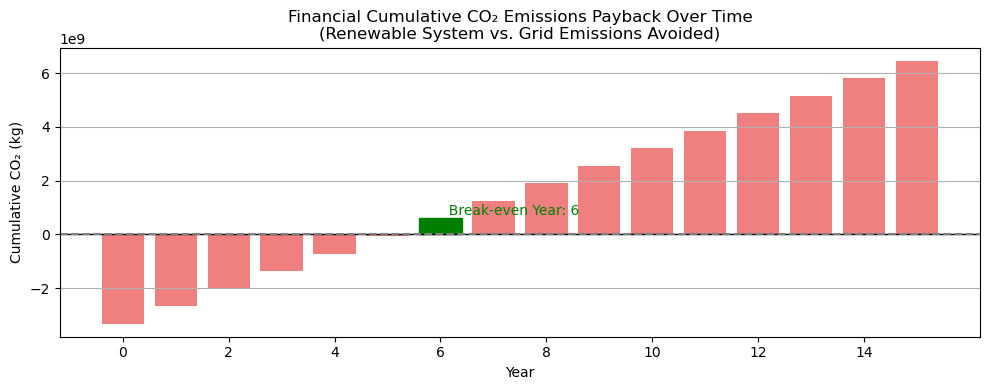

6

In [27]:
import matplotlib.pyplot as plt
import numpy as np


# === Project lifetime and CO2 flow ===
project_lifetime = 15  # Assume 30 years for LCA horizon

# CO2 flows: Year 0 is the "CO2 investment" (debt), rest are yearly avoided grid emissions
co2_flows = [-Total_renewable_emissions] + [total_annual_grid] * project_lifetime
cumulative_co2 = np.cumsum(co2_flows)

# Plotting
plt.figure(figsize=(10, 4))
bars = plt.bar(range(project_lifetime + 1), cumulative_co2, color='lightcoral')
plt.axhline(0, color='black', linewidth=1)
plt.axhline(y=0, linestyle='--', color='gray')

# Highlight break-even year
break_even_year = np.argmax(cumulative_co2 >= 0)
bars[break_even_year].set_color('green')

# Labels and title
plt.title('Financial Cumulative CO₂ Emissions Payback Over Time\n(Renewable System vs. Grid Emissions Avoided)')
plt.xlabel('Year')
plt.ylabel('Cumulative CO₂ (kg)')
plt.xticks(range(0, project_lifetime + 1, 2))
plt.grid(axis='y')

# Optional annotation for break-even year
plt.text(break_even_year, cumulative_co2[break_even_year],
         f'  Break-even Year: {break_even_year}', color='green', va='bottom')

plt.tight_layout()
plt.show()

# Output payback year for reference
break_even_year
